Epoch 1/10, Loss: 0.6354
Epoch 2/10, Loss: 0.5425
Epoch 3/10, Loss: 0.5232
Epoch 4/10, Loss: 0.3675
Epoch 5/10, Loss: 0.2965
Epoch 6/10, Loss: 0.2719
Epoch 7/10, Loss: 0.3428
Epoch 8/10, Loss: 0.2545
Epoch 9/10, Loss: 0.1628
Epoch 10/10, Loss: 0.2224


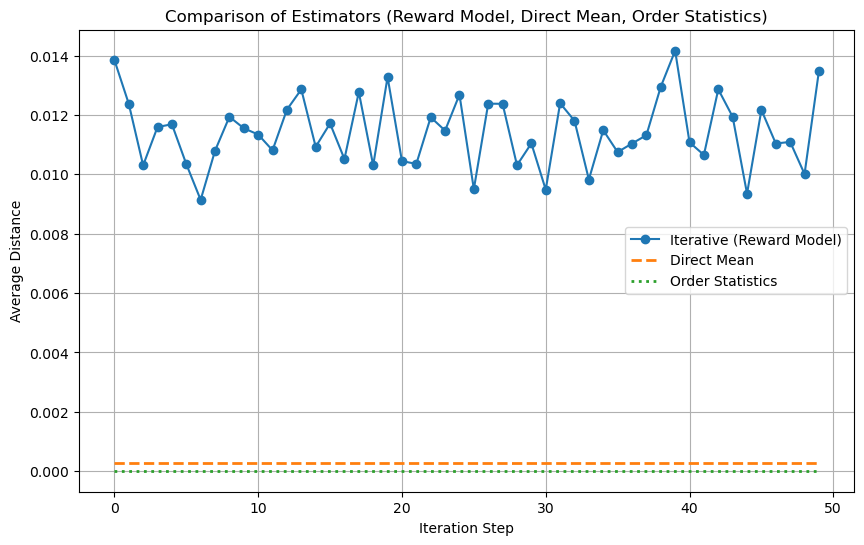

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Parameters
r = np.sqrt(3)  # Range factor for uniform distribution
theta = 0  # True theta (as a scalar)
m = 1000  # Number of samples in the first batch
n = 10**5  # Number of samples in subsequent batches
d = 1  # Dimensions
t = 50  # Number of steps
k = 5  # Number of repetitions
s = 1  # Scale parameter for uniform distribution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# True theta vector
theta_vec = np.ones(d) * theta

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Function to generate labeled training data for pairwise comparison
def generate_labeled_data_pairwise(theta_vec, size=10000):
    """
    Generate labeled training data for a reward model.
    - Each input consists of two points (x_1, x_2).
    - Output is a label indicating which point is closer.
    """
    data = np.random.uniform(low=theta_vec - r * s, high=theta_vec + r * s, size=(2 * size, d))
    distances = np.linalg.norm(data - theta_vec, axis=1)
    
    # Reshape into pairs
    data_pairs = data.reshape(size, 2, d)
    distances_pairs = distances.reshape(size, 2)

    # Determine which point in each pair is closer
    closer_idx = np.argmin(distances_pairs, axis=1)
    
    # Create input features: concatenate the two points
    X_train = np.hstack((data_pairs[:, 0, :], data_pairs[:, 1, :]))

    # Labels: 1 if first point is closer, 0 otherwise
    y_train = (closer_idx == 0).astype(int)

    return torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device)


# Define a two-layer neural network for the reward model
class RewardModel(nn.Module):
    def __init__(self, input_dim):
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)  # First hidden layer with 16 neurons
        self.fc2 = nn.Linear(16, 1)  # Output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = self.sigmoid(self.fc2(x))  # Apply Sigmoid activation to the output layer
        return x


# Train the reward model
def train_reward_model(theta_vec, epochs=10, batch_size=64):
    X_train, y_train = generate_labeled_data_pairwise(theta_vec, size=10000)
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = RewardModel(input_dim=2 * d).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    
    return model

# Function to classify and filter data using the reward model
def classify_and_filter_data(model, data, filter_ratio=0.5):
    """
    Use the trained reward model to compare pairs of data points.
    - Inputs are pairs of new generated points.
    - The model predicts which is better and keeps the selected data.
    """
    size = len(data) // 2  # Number of pairs
    data_pairs = data[:size * 2].reshape(size, 2, d)  # Reshape into (size, 2, d)

    # Prepare input features for the model
    X_test = torch.tensor(np.hstack((data_pairs[:, 0, :], data_pairs[:, 1, :])), dtype=torch.float32).to(device)

    # Predict which point is better
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy().squeeze()

    # Select the better data points
    selected_data = np.where(predictions[:, None] > 0.5, data_pairs[:, 0, :], data_pairs[:, 1, :])

    return selected_data

# Train the reward model
reward_model = train_reward_model(theta_vec)

# Store results
iterative_distances = []
direct_errors = []
order_stat_errors = []

for _ in range(k):
    distances = []
    
    # Generate initial batch
    initial_data = np.random.uniform(low=theta_vec - r * s, high=theta_vec + r * s, size=(m, d))
    
    # Compute direct mean estimator
    direct_mean = compute_mean(initial_data)
    direct_error = np.linalg.norm(direct_mean - theta_vec)**2
    
    # Compute order statistics estimator (average of min and max)
    order_stat_min = np.min(initial_data, axis=0)
    order_stat_max = np.max(initial_data, axis=0)
    order_stat_mean = (order_stat_min + order_stat_max) / 2
    order_stat_error = np.linalg.norm(order_stat_mean - theta_vec)**2

    # Store direct mean and order statistics estimators
    direct_errors.append([direct_error] * t)
    order_stat_errors.append([order_stat_error] * t)

    mean = direct_mean  # Start with direct mean
    
    for step in range(t):
        if step > 0:
            # Generate 2n samples (since we form pairs) around the estimated mean from the previous step
            data = np.random.uniform(low=mean - r * s, high=mean + r * s, size=(2 * n, d))
            
            # Use the trained classifier to filter good samples
            filtered_data = classify_and_filter_data(reward_model, data)
            if len(filtered_data) > 0:
                mean = compute_mean(filtered_data)  # Update the mean if there are filtered samples
            
        # Compute distance to true theta
        distance_to_theta = np.linalg.norm(mean - theta_vec)
        distances.append(distance_to_theta)
    
    iterative_distances.append(distances)

# Compute the average error over all repetitions
average_iterative_distances = np.mean(iterative_distances, axis=0)
average_direct_errors = np.mean(direct_errors, axis=0)
average_order_stat_errors = np.mean(order_stat_errors, axis=0)

# Ensure proper shape before plotting
average_iterative_distances = np.array(average_iterative_distances).flatten()
average_direct_errors = np.array(average_direct_errors).flatten()
average_order_stat_errors = np.array(average_order_stat_errors).flatten()

# Plot results
plt.figure(figsize=(10, 6))

# Plot iterative estimator (learned reward model)
plt.plot(range(t), average_iterative_distances, marker='o', linestyle='-', label="Iterative (Reward Model)")

# Plot direct mean estimator
plt.plot(range(t), average_direct_errors, linestyle='--', label="Direct Mean", linewidth=2)

# Plot order statistics estimator
plt.plot(range(t), average_order_stat_errors, linestyle=':', label="Order Statistics", linewidth=2)

plt.title(f"Comparison of Estimators (Reward Model, Direct Mean, Order Statistics)")
plt.xlabel("Iteration Step")
plt.ylabel("Average Distance")
plt.grid(True)
plt.legend()
plt.show()


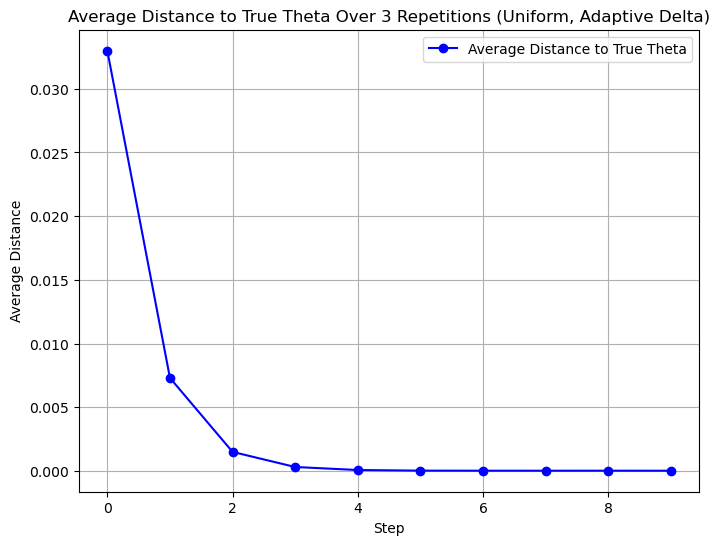

Step 0: Average Distance to True Theta = 0.032985
Step 1: Average Distance to True Theta = 0.007297
Step 2: Average Distance to True Theta = 0.001491
Step 3: Average Distance to True Theta = 0.000306
Step 4: Average Distance to True Theta = 0.000070
Step 5: Average Distance to True Theta = 0.000021
Step 6: Average Distance to True Theta = 0.000016
Step 7: Average Distance to True Theta = 0.000015
Step 8: Average Distance to True Theta = 0.000016
Step 9: Average Distance to True Theta = 0.000014


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
s = 1  # Scale parameter for uniform distribution
theta = 0  # True theta (as a scalar)
m = 20  # Number of samples in the first batch
n = 10**5  # Number of samples in subsequent batches
d = 5  # Dimensions
t = 10  # Number of steps
delta_default = 1  # Default probability of selecting closer points
rho = 0  # Threshold for distance difference
k = 3  # Number of repetitions

# True theta vector
theta_vec = np.ones(d) * theta

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Function to filter data points with an adjusted delta probability
def probabilistic_filter_data(data1, data2, theta_vec, delta_default, rho):
    # Compute distances of points in both datasets to the true theta
    dist1 = np.linalg.norm(data1 - theta_vec, axis=1)
    dist2 = np.linalg.norm(data2 - theta_vec, axis=1)
    
    # Initialize selected data
    selected_data = []
    
    # Iterate through both datasets point by point
    for i in range(len(dist1)):
        # Adjust delta dynamically based on distance difference
        delta = delta_default if abs(dist1[i] - dist2[i]) >= rho else 0.5
        
        if dist1[i] < dist2[i]:
            # dist1 < dist2: Choose data1 with delta probability, otherwise choose data2
            if np.random.rand() < delta:
                selected_data.append(data1[i])
            else:
                selected_data.append(data2[i])
        else:
            # dist1 >= dist2: Choose data2 with delta probability, otherwise choose data1
            if np.random.rand() < delta:
                selected_data.append(data2[i])
            else:
                selected_data.append(data1[i])
    
    # Convert the list to a NumPy array and return
    return np.array(selected_data)

# Perform the process k times
all_distances = []  # To store distances for all repetitions
for _ in range(k):
    distances = []  # Store distances for a single repetition
    mean = None  # Initialize the mean
    for step in range(t):
        if step == 0:
            # First step: Generate m samples uniformly around true theta
            data = np.random.uniform(low=theta_vec - s, high=theta_vec + s, size=(m, d))
            mean = compute_mean(data)
        else:
            # Subsequent steps: Generate n samples around the estimated mean from the previous step
            data1 = np.random.uniform(low=mean - s, high=mean + s, size=(n, d))
            data2 = np.random.uniform(low=mean - s, high=mean + s, size=(n, d))
            # Probabilistically filter data based on proximity to the true theta
            filtered_data = probabilistic_filter_data(data1, data2, theta_vec, delta_default, rho)
            # Compute the mean of the filtered data
            mean = compute_mean(filtered_data)
        
        # Compute distance to true theta
        distance_to_theta = np.linalg.norm(mean - theta_vec)**2
        distances.append(distance_to_theta)
    all_distances.append(distances)

# Compute the average error over all repetitions
average_distances = np.mean(all_distances, axis=0)

# Plot the average error over steps
plt.figure(figsize=(8, 6))
plt.plot(range(t), average_distances, marker='o', linestyle='-', color='blue', label="Average Distance to True Theta")
plt.title(f"Average Distance to True Theta Over {k} Repetitions (Uniform, Adaptive Delta)")
plt.xlabel("Step")
plt.ylabel("Average Distance")
plt.grid()
plt.legend()
plt.show()

# Print the average distances for inspection
for step, avg_distance in enumerate(average_distances):
    print(f"Step {step}: Average Distance to True Theta = {avg_distance:.6f}")


## Gaussian

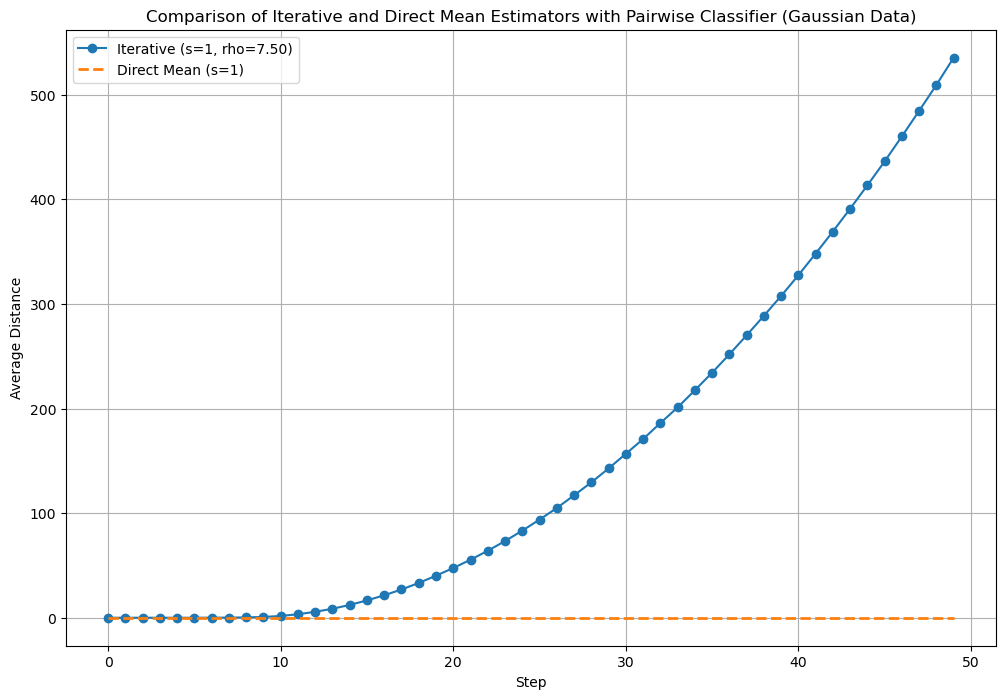

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Parameters
r = 1  # Range factor for Gaussian spread
theta = 1  # True theta (as a scalar)
m = 1000  # Number of samples in the first batch
n = 10**4  # Number of samples in subsequent batches
d = 1  # Dimensions
t = 50  # Number of steps
repetitions = 1  # Number of repetitions
s_values = [1]  # Different scale parameter values
rho_values = [1.5]  # Different rho values to test

# True theta vector
theta_vec = np.ones(d) * theta

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Function to generate labeled training data for pairwise classification
def generate_labeled_data_pairwise(theta, size):
    """
    Generate labeled training data for learning a classifier.
    - Each input consists of two concatenated points [x_1, x_2] (a 2d feature vector).
    - Output label: 1 if x_1 is closer to theta, otherwise 0.
    """
    # Generate 2*size samples from a **Gaussian distribution**
    data = np.random.normal(loc=theta, scale=0.5* s * r, size=(2 * size, d))
    distances = np.linalg.norm(data - theta_vec, axis=1)

    # Reshape into pairs
    data_pairs = data.reshape(size, 2, d)
    distances_pairs = distances.reshape(size, 2)

    # Determine which point in each pair is closer
    closer_idx = np.argmin(distances_pairs, axis=1)  # Index of closer point

    # Concatenate features to create 2d input vectors
    X_train = np.hstack((data_pairs[:, 0, :], data_pairs[:, 1, :]))

    # Labels: 1 if first point is closer, 0 otherwise
    y_train = (closer_idx == 0).astype(int)

    return X_train, y_train

# Function to train the SVM classifier
def train_pairwise_classifier(theta, size=100):
    """
    Train an SVM classifier to predict which point in a pair is closer.
    """
    X_train, y_train = generate_labeled_data_pairwise(theta, size)
    model = SVC(kernel='linear', probability=True)  # Linear SVM with probability estimates
    model.fit(X_train, y_train)  # Train the classifier
    return model

# Function to classify and select the closer data point
def classify_and_filter_pairs(model, data):
    """
    Use the trained classifier to compare pairs of data points.
    - Inputs are pairs of new generated points.
    - The model predicts which point is closer.
    - Keep only the selected points for refinement.
    """
    size = len(data) // 2  # Number of pairs
    data_pairs = data[:size * 2].reshape(size, 2, d)  # Reshape into (size, 2, d)
    
    # Prepare features for classification
    X_test = np.hstack((data_pairs[:, 0, :], data_pairs[:, 1, :]))

    # Predict which point is closer
    predictions = model.predict(X_test)

    # Select the closer data points
    selected_data = np.where(predictions[:, None], data_pairs[:, 0, :], data_pairs[:, 1, :])

    return selected_data

# Function to compare pairs and select the closer one
def pairwise_select_closer(data, theta_true):
    """
    Select the closer point from each pair based on true distances.
    
    Parameters:
    - data: Generated data points (numpy array of shape (N, d))
    - theta_vec: The true theta value (numpy array of shape (d,))
    
    Returns:
    - Selected subset of data points, keeping one from each pair
    """
    size = len(data) // 2  # Number of pairs
    data_pairs = data[:size * 2].reshape(size, 2, d)  # Reshape into (size, 2, d)

    # Compute distances of both points in each pair to theta
    dist1 = np.linalg.norm(data_pairs[:, 0, :] - theta_true, axis=1)
    dist2 = np.linalg.norm(data_pairs[:, 1, :] - theta_true, axis=1)

    # Select the closer point from each pair
    closer_idx = (dist1 < dist2).astype(int)  # 0 if first is closer, 1 if second is closer
    selected_data = data_pairs[np.arange(size), closer_idx, :]  # Choose closer points

    return selected_data


# Initialize storage for results
results = {}
direct_errors = {}

for s in s_values:
    all_direct_errors = []
    all_iterative_distances = []

    for _ in range(repetitions):  # Repeat the entire process
        # Generate initial data using **Gaussian distribution**
        initial_data = np.random.normal(loc=theta_vec, scale=s * r, size=(m, d))
        
        # Compute the initial estimator (theta_hat)
        theta_hat = compute_mean(initial_data)
        direct_error = np.linalg.norm(theta_hat - theta_vec)**2
        all_direct_errors.append(direct_error)

        # Train the classifier
        #pairwise_classifier = train_pairwise_classifier(theta_hat)

        for rho in rho_values:
            #rho_adjusted = rho * s  # Adjust rho based on the scale parameter
            distances = []  # Store distances for a single iteration
            mean = theta_hat  # Use the initial mean as the starting point
            
            # Compute the initial distance for the first step
            initial_distance = np.linalg.norm(mean - theta_vec)**2
            distances.append(initial_distance)
            
            for step in range(1, t):  # Start from step 1
                # Generate 2n new data points using **Gaussian distribution**
                data = np.random.normal(loc=mean, scale=s * r, size=(2 * n, d))

                # Use trained classifier for filtering
                filtered_data = pairwise_select_closer(data, theta_vec)

                if len(filtered_data) > 0:
                    mean = compute_mean(filtered_data)
                else:
                    mean = mean  # If no samples pass the filter, keep the last mean
                
                # Compute distance to true theta
                distance_to_theta = np.linalg.norm(mean - theta_vec)**2
                distances.append(distance_to_theta)

            all_iterative_distances.append(distances)

    # Compute the average over all repetitions
    average_direct_error = np.mean(all_direct_errors)
    average_iterative_distances = np.mean(all_iterative_distances, axis=0)
    
    # Store the results
    direct_errors[s] = [average_direct_error] * t
    results[(s, rho_adjusted)] = average_iterative_distances

# Plot the average error over steps for different s and rho values
plt.figure(figsize=(12, 8))

# Plot iterative method
for (s, rho), avg_distances in results.items():
    plt.plot(range(t), avg_distances, marker='o', linestyle='-', label=f"Iterative (s={s}, rho={rho:.2f})")

# Plot direct mean method
for s, avg_error in direct_errors.items():
    plt.plot(range(t), avg_error, linestyle='--', label=f"Direct Mean (s={s})", linewidth=2)

plt.title("Comparison of Iterative and Direct Mean Estimators with Pairwise Classifier (Gaussian Data)")
plt.xlabel("Step")
plt.ylabel("Average Distance")
plt.grid()
plt.legend()
plt.show()


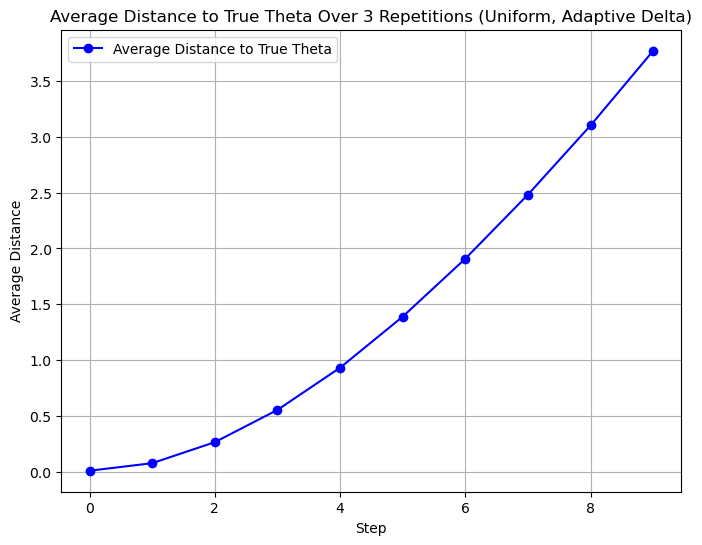

Step 0: Average Distance to True Theta = 0.007868
Step 1: Average Distance to True Theta = 0.075482
Step 2: Average Distance to True Theta = 0.263759
Step 3: Average Distance to True Theta = 0.552877
Step 4: Average Distance to True Theta = 0.930918
Step 5: Average Distance to True Theta = 1.388558
Step 6: Average Distance to True Theta = 1.908112
Step 7: Average Distance to True Theta = 2.482169
Step 8: Average Distance to True Theta = 3.102019
Step 9: Average Distance to True Theta = 3.771342


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Parameters
s = 1  # Scale parameter for uniform distribution
theta = 0  # True theta (as a scalar)
m = 200  # Number of samples in the first batch
n = 10**5  # Number of samples in subsequent batches
d = 5  # Dimensions
t = 10  # Number of steps
delta_default = 1  # Default probability of selecting closer points
rho = 0  # Threshold for distance difference
k = 3  # Number of repetitions
r = 1  # Radius scaling for sampling
bias_probability = 0.7  # Probability of selecting closer points

# True theta vector
theta_vec = np.ones(d) * theta

def compute_mean(data):
    return np.mean(data, axis=0)

def generate_labeled_data_pairwise(theta_hat, size):
    data = np.zeros((2 * size, d))
    for i in range(2 * size):
        if np.random.rand() < bias_probability:
            data[i] = np.random.uniform(low=theta - r * s, high=theta + 0.1 * r * s, size=d)
        else:
            data[i] = np.random.uniform(low=theta_hat - r * s, high=theta_hat + r * s, size=d)
    distances = np.linalg.norm(data - theta, axis=1)
    data_pairs = data.reshape(size, 2, d)
    distances_pairs = distances.reshape(size, 2)
    closer_idx = np.argmin(distances_pairs, axis=1)
    X_train = np.hstack((data_pairs[:, 0, :], data_pairs[:, 1, :]))
    y_train = (closer_idx == 0).astype(int)
    return X_train, y_train

def train_pairwise_classifier(theta_hat, size=400):
    X_train, y_train = generate_labeled_data_pairwise(theta_hat, size)
    model = SVC(kernel='linear', probability=True)
    model.fit(X_train, y_train)
    return model

def classify_filtered_data(classifier, data1, data2):
    X_test = np.hstack((data1, data2))
    predictions = classifier.predict(X_test)
    
    # Convert predictions into a boolean mask
    mask = predictions == 1
    
    # Select elements based on the mask
    selected_data = np.where(mask[:, np.newaxis], data1, data2)
    
    return selected_data

all_distances = []
for _ in range(k):
    distances = []
    mean = None
    classifier = None
    for step in range(t):
        if step == 0:
            data = np.random.uniform(low=theta_vec - s, high=theta_vec + s, size=(m, d))
            mean = compute_mean(data)
            classifier = train_pairwise_classifier(mean)  # Train classifier only at step 0
        else:
            data1 = np.random.uniform(low=mean - s, high=mean + s, size=(n, d))
            data2 = np.random.uniform(low=mean - s, high=mean + s, size=(n, d))
            if classifier:
                filtered_data = classify_filtered_data(classifier, data1, data2)
            else:
                filtered_data = data1  # Default to using data1 if no classifier is available
            mean = compute_mean(filtered_data)
        distance_to_theta = np.linalg.norm(mean - theta_vec) ** 2
        distances.append(distance_to_theta)
    all_distances.append(distances)

average_distances = np.mean(all_distances, axis=0)

plt.figure(figsize=(8, 6))
plt.plot(range(t), average_distances, marker='o', linestyle='-', color='blue', label="Average Distance to True Theta")
plt.title(f"Average Distance to True Theta Over {k} Repetitions (Uniform, Adaptive Delta)")
plt.xlabel("Step")
plt.ylabel("Average Distance")
plt.grid()
plt.legend()
plt.show()

for step, avg_distance in enumerate(average_distances):
    print(f"Step {step}: Average Distance to True Theta = {avg_distance:.6f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
s = 1  # Standard deviation for Gaussian distribution
theta = 1  # True theta (as a scalar)
m = 20  # Number of samples in the first batch
n = 10**4  # Number of samples in subsequent batches
d = 5  # Dimensions
t = 10  # Number of steps
delta_default = 1  # Default probability of selecting closer points
rho = 1  # Threshold for distance difference
k = 10  # Number of repetitions
residual_threshold = 0  # Threshold to filter based on residuals

# True theta vector (for regression coefficients)
theta_vec = np.ones(d) * theta

# Function to generate data for regression
def generate_regression_data(size, theta_vec, s):
    # X: Random feature matrix, y: Output with Gaussian noise
    X = np.random.normal(loc=0, scale=s, size=(size, len(theta_vec)))
    y = X @ theta_vec + np.random.normal(loc=0, scale=s, size=size)
    return X, y

# Function to compute the mean of a dataset
def compute_mean(data):
    return np.mean(data, axis=0)

# Function to estimate the coefficient using Ordinary Least Squares (OLS)
def estimate_coefficients(X, y):
    # Using the OLS formula: theta_hat = (X^T X)^(-1) X^T y
    X_transpose = X.T
    theta_hat = np.linalg.inv(X_transpose @ X) @ X_transpose @ y
    return theta_hat

# Function to filter data points based on residuals
def filter_by_residuals(X, y, true_theta, residual_threshold):
    # Calculate the predicted y values
    y_pred = X @ true_theta
    # Calculate residuals (difference between true and predicted y)
    residuals = np.abs(y - y_pred)
    # Keep only the points where the residual is below the threshold
    mask = residuals < residual_threshold
    return X[mask], y[mask]

# Perform the process k times
all_errors = []  # To store errors for all repetitions
for _ in range(k):
    errors = []  # Store errors for a single repetition
    estimated_theta = None  # Initialize estimated theta
    for step in range(t):
        if step == 0:
            # First step: Generate m samples from regression model centered at true theta
            X, y = generate_regression_data(m, theta_vec, s)
            # Estimate the coefficients using OLS
            estimated_theta = estimate_coefficients(X, y)
        else:
            # Subsequent steps: Generate n samples around the estimated theta from the previous step
            X1, y1 = generate_regression_data(n, estimated_theta, s)
            X2, y2 = generate_regression_data(n, estimated_theta, s)
            
            # Filter the data based on residuals using the true theta
            filtered_X, filtered_y = filter_by_residuals(X1, y1, theta_vec, residual_threshold)
            
            # Estimate the coefficients using OLS with the filtered data
            estimated_theta = estimate_coefficients(filtered_X, filtered_y)
        
        # Compute the error in terms of the coefficient estimate
        error = np.linalg.norm(estimated_theta - theta_vec)**2  # Squared error between estimated and true theta
        errors.append(error)
    all_errors.append(errors)

# Compute the average error over all repetitions
average_errors = np.mean(all_errors, axis=0)

# Plot the average error over steps
plt.figure(figsize=(8, 6))
plt.plot(range(t), average_errors, marker='o', linestyle='-', color='blue', label="Average Error in Coefficient Estimation")
plt.title(f"Average Error in Coefficient Estimation Over {k} Repetitions (Regression, Residual Filtering)")
plt.xlabel("Step")
plt.ylabel("Average Squared Error")
plt.grid()
plt.legend()
plt.show()

# Print the average errors for inspection
for step, avg_error in enumerate(average_errors):
    print(f"Step {step}: Average Squared Error = {avg_error:.6f}")
